# Análise de partidas Xadrez (Lichess)

## Objetivo
(.....)

## Importando bibliotecas e Dados

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [56]:
df = pd.read_csv('games.csv')

df.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


## Limpeza de Dados

In [57]:
# Pegando somente colunas que vou usar
df = df[['turns', 'victory_status', 'winner', 'white_rating', 'black_rating', 'opening_name', 'opening_ply']]
df.head()

,turns,victory_status,winner,white_rating,black_rating,opening_name,opening_ply
0,13,outoftime,white,1500,1191,Slav Defense: Exchange Variation,5
1,16,resign,black,1322,1261,Nimzowitsch Defense: Kennedy Variation,4
2,61,mate,white,1496,1500,King's Pawn Game: Leonardis Variation,3
3,61,mate,white,1439,1454,Queen's Pawn Game: Zukertort Variation,3
4,95,mate,white,1523,1469,Philidor Defense,5


In [58]:
df.shape

(20058, 7)

In [59]:
# Verificando valores nulos
print(df.isnull().sum())

turns             0
victory_status    0
winner            0
white_rating      0
black_rating      0
opening_name      0
opening_ply       0
dtype: int64


In [60]:
# Verificando duplicatas
df.duplicated().sum()

948

In [61]:
# Removendo duplicatas
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19110 entries, 0 to 20057
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   turns           19110 non-null  int64 
 1   victory_status  19110 non-null  object
 2   winner          19110 non-null  object
 3   white_rating    19110 non-null  int64 
 4   black_rating    19110 non-null  int64 
 5   opening_name    19110 non-null  object
 6   opening_ply     19110 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.2+ MB


## Análise Exploratória dos Dados (EDA)

In [63]:
# cores para gráficos
colorB, colorD, colorW = ['#2D1803', '#7F6647', '#D2B48C']

In [64]:
ratings = pd.concat([df['white_rating'], df['black_rating']])  # juntando ratings de preto e branco
ratings.value_counts().head()

1500    1547
1501      95
1480      89
1562      85
1536      83
Name: count, dtype: int64

In [ ]:
### Distribuição das classificações dos jogadores

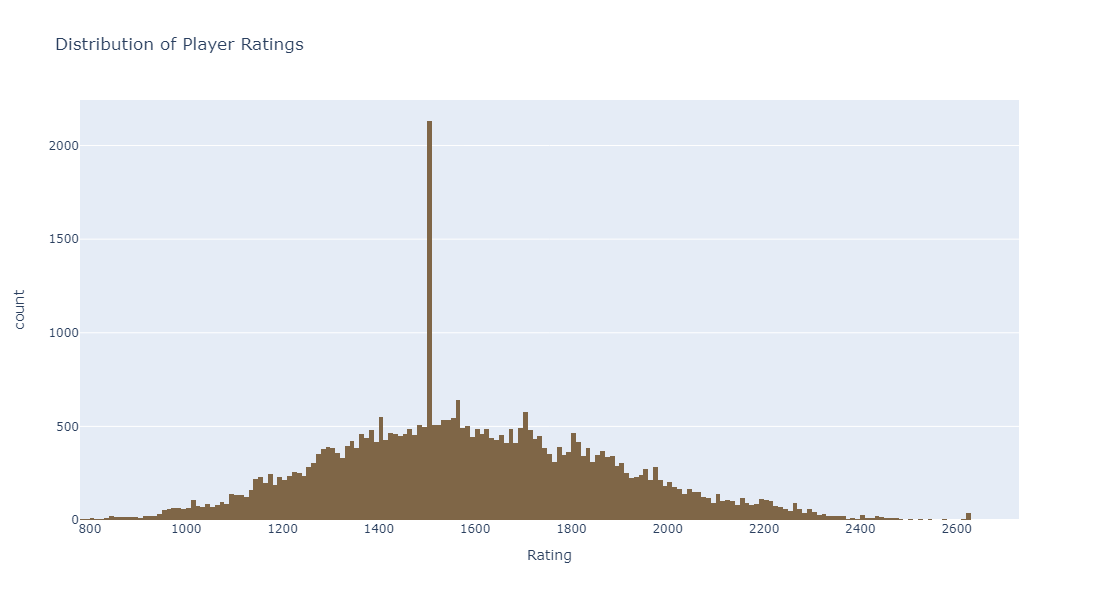

In [28]:
fig = px.histogram(ratings, 
                   title='Distribution of Player Ratings',
                   labels={'value':'Rating'},
                   width=1000, height=600,
                   color_discrete_sequence=[colorD]
                  )
fig.update_layout(showlegend=False)
fig.show()

### Distribuição de taxas de Vitória/Empate por Cor das peças

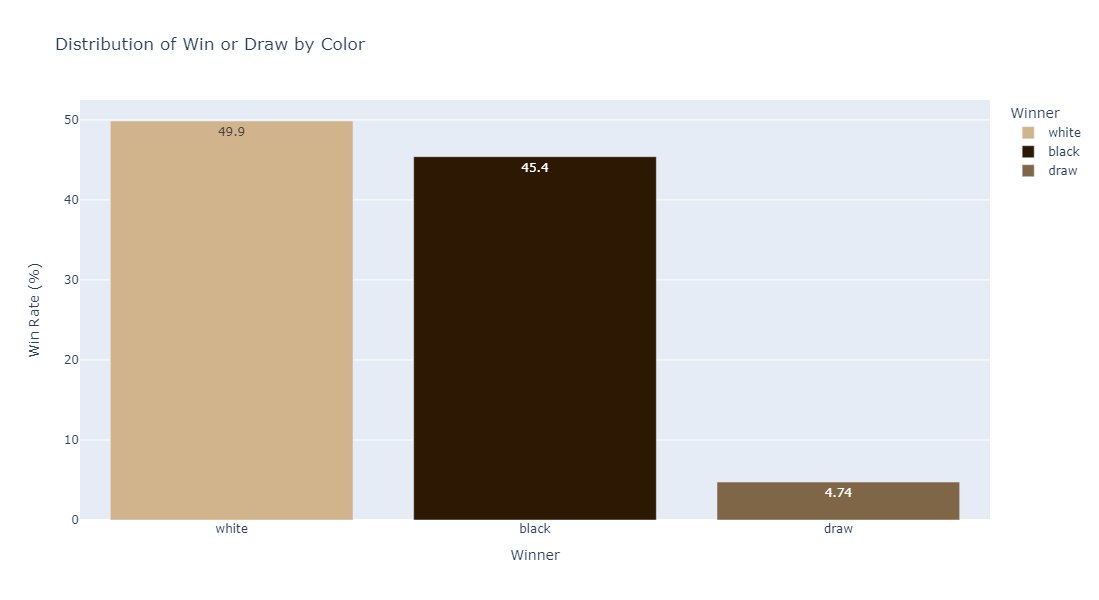

In [9]:
# Calculando a distribuição de vitórias por cor
count_winner_color = (df['winner'].value_counts(normalize=True)*100).round(2)

# Criando um DataFrame a partir da distribuição calculada
winner_color_df = count_winner_color.reset_index()
winner_color_df.columns = ['winner', 'proportion']

# Definindo as cores para cada categoria
color_map = {'white': colorW, 'black': colorB, 'draw': colorD}

# Gráfico de barras
fig = px.bar(winner_color_df,
             x='winner', y='proportion',
             width=1000, height=600,
             text_auto='.3s',
             title='Distribution of Win or Draw by Color',
             labels={'winner': 'Winner', 'proportion': 'Win Rate (%)'},
             color='winner',
             color_discrete_map=color_map)

fig.show()

### Distribuição de como o jogo acabou (desistênica, cheque-mate, sem tempo, empate)

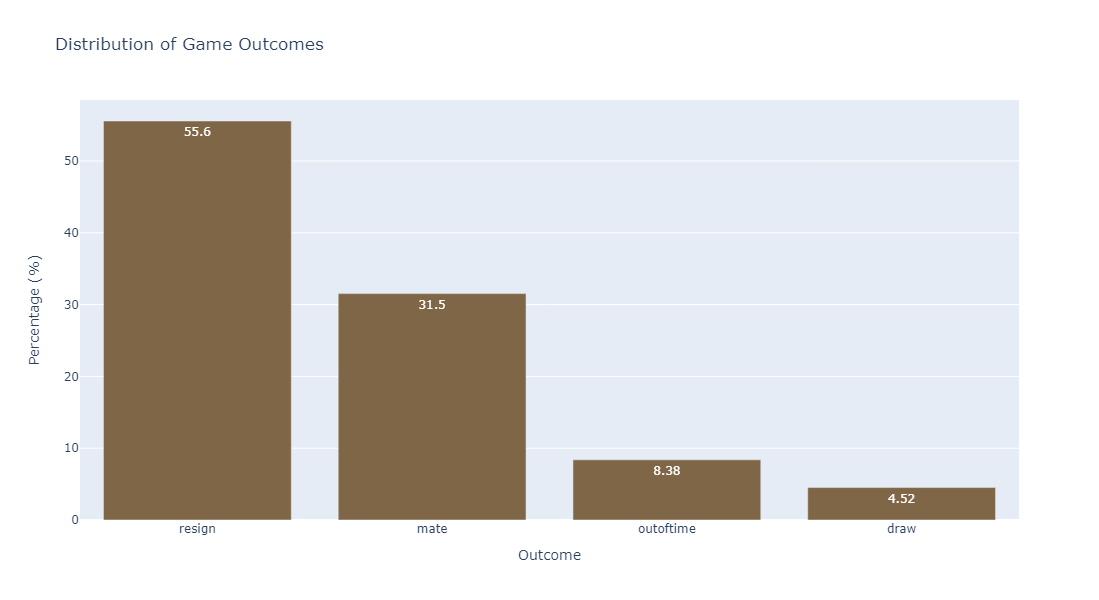

In [10]:
# Calculando a distribuição de status de vitória
count_victory_status = (df['victory_status'].value_counts(normalize=True) * 100).round(2)

# Criando um DataFrame a partir da distribuição calculada
victory_status_df = count_victory_status.reset_index()
victory_status_df.columns = ['victory_status', 'proportion']

# Gráfico de barras com uma cor só
fig = px.bar(victory_status_df,
             x='victory_status', y='proportion',
             width=1000, height=600, 
             text_auto='.3s',  # value on the bar
             title='Distribution of Game Outcomes',
             labels={'victory_status': 'Outcome', 'proportion': 'Percentage (%)'},
             color_discrete_sequence=[colorD])

fig.show()

### Taxas de vitória entre diferentes níveis de classificação

In [11]:
# Criando "Rating do Vencedor"
df['winner_rating'] = df.apply(lambda row: row['white_rating'] if row['winner'] == 'white' else
                                           row['black_rating'] if row['winner'] == 'black' else
                                           int((row['white_rating'] + row['black_rating']) / 2),
                               axis=1)

In [12]:
# Criando "Divisão de ratings dos vencedores"
bins = [0, 1000, 1400, 1800, 2200, 3000]
labels = ['<1000', '1000-1399', '1400-1799', '1800-2199', '2200+']

# Criando winner_class
df['winner_class'] = pd.cut(df['winner_rating'], bins=bins, labels=labels)

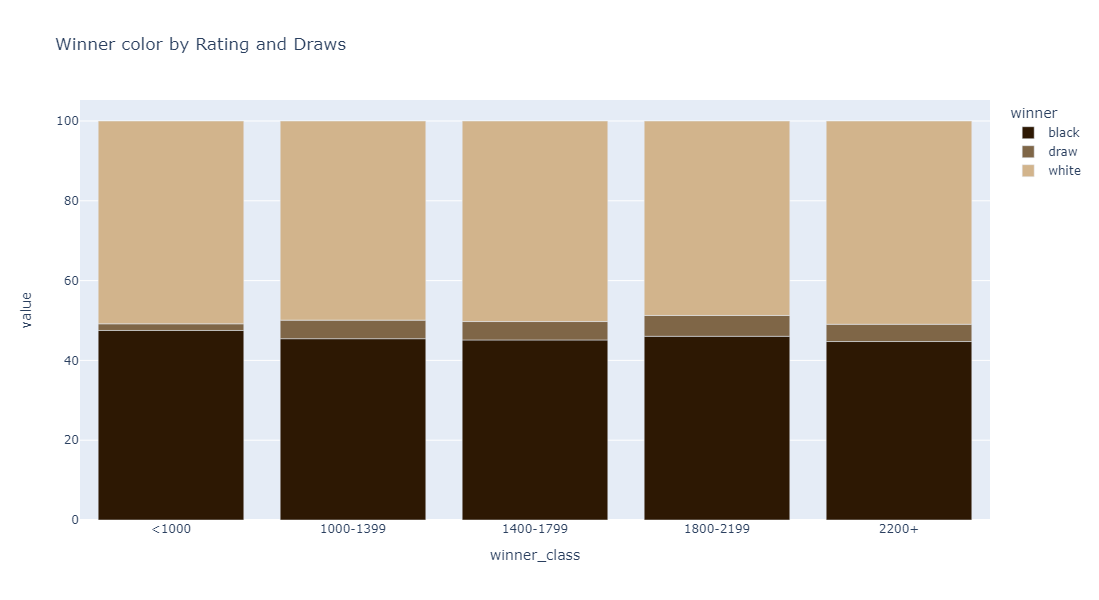

In [13]:
# tabela
win_rates_by_class = df.groupby('winner_class', observed=True)['winner'].value_counts(normalize=True).unstack()

# plotando gráfico
px.bar((win_rates_by_class*100).round(2),
       title='Winner color by Rating and Draws',
       width=800, height=600, 
       # cores
       color='winner', 
       color_discrete_sequence=[colorB, colorD, colorW])

### Top 10 Aberturas mais usadas

In [14]:
# Aberturas mais usadas
top_openings = pd.DataFrame(df['opening_name'].value_counts(normalize=True)*100).round(2).head(10)
print('Top 10 Aberturas mais usadas')
top_openings.columns = ['%']
top_openings

Top 10 Aberturas mais usadas


,%
opening_name,
Van't Kruijs Opening,1.83
Sicilian Defense,1.78
Sicilian Defense: Bowdler Attack,1.48
Scotch Game,1.35
French Defense: Knight Variation,1.35
Scandinavian Defense: Mieses-Kotroc Variation,1.29
Queen's Pawn Game: Mason Attack,1.16
Queen's Pawn Game: Chigorin Variation,1.14
Scandinavian Defense,1.11


### Aberturas com maior taxa de sucesso (Brancas x Pretas x Empate)

In [15]:
# filtrando aberturas que possuem somente mais de 30 dados
openings30 = df['opening_name'].value_counts() > 30
openings30 = openings30[openings30].index
openings30_df = df[df['opening_name'].isin(openings30)]
# agrupando aberturas por vencedor
openings_group_by_winner = (openings30_df.groupby('opening_name')['winner'].value_counts(normalize=True)*100).round(2).unstack()

# melhores aberturas para brancas
best_openings_white = openings_group_by_winner.sort_values(by='white', ascending=False).head(5)
# melhores aberturas para pretas
best_openings_black = openings_group_by_winner.sort_values(by='black', ascending=False).head(5)
# aberturas com mais empates
best_openings_draw = openings_group_by_winner.sort_values(by='draw', ascending=False).head(5)
# aberturas com menos empates
best_openings_no_draw = openings_group_by_winner.sort_values(by='draw', ascending=True).head(5)

# cores para os gráficos
opening_colors = [colorB, colorD, colorW]

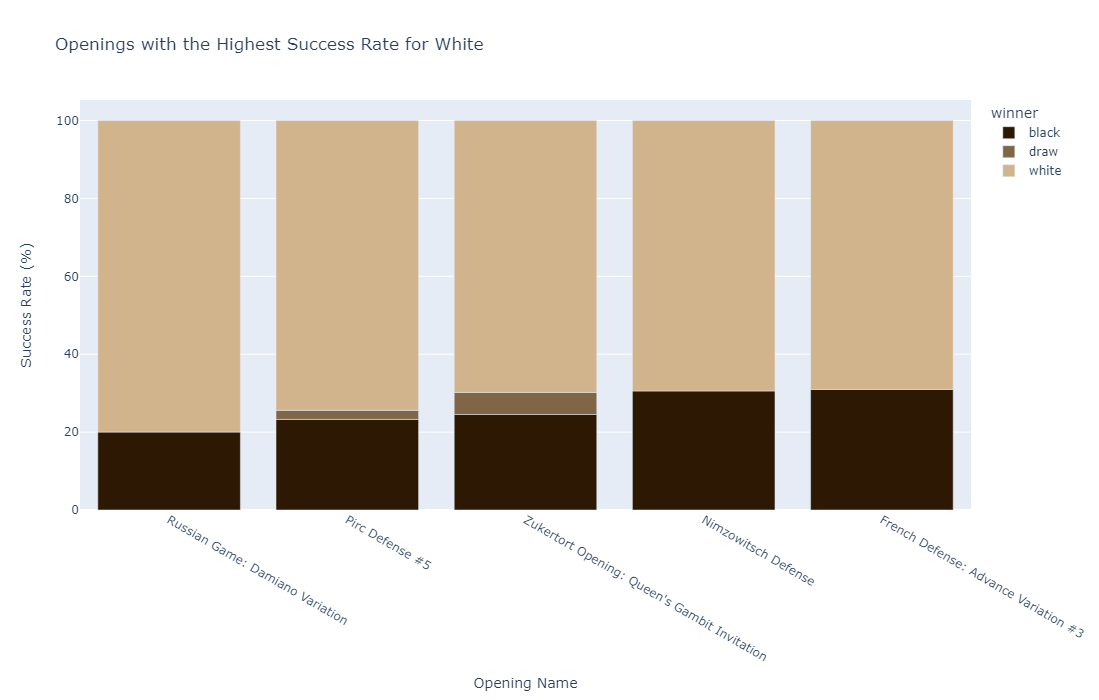

In [16]:
# Plot das aberturas com a maior taxa de sucesso para peças brancas
fig = px.bar(best_openings_white, 
             title='Openings with the Highest Success Rate for White',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

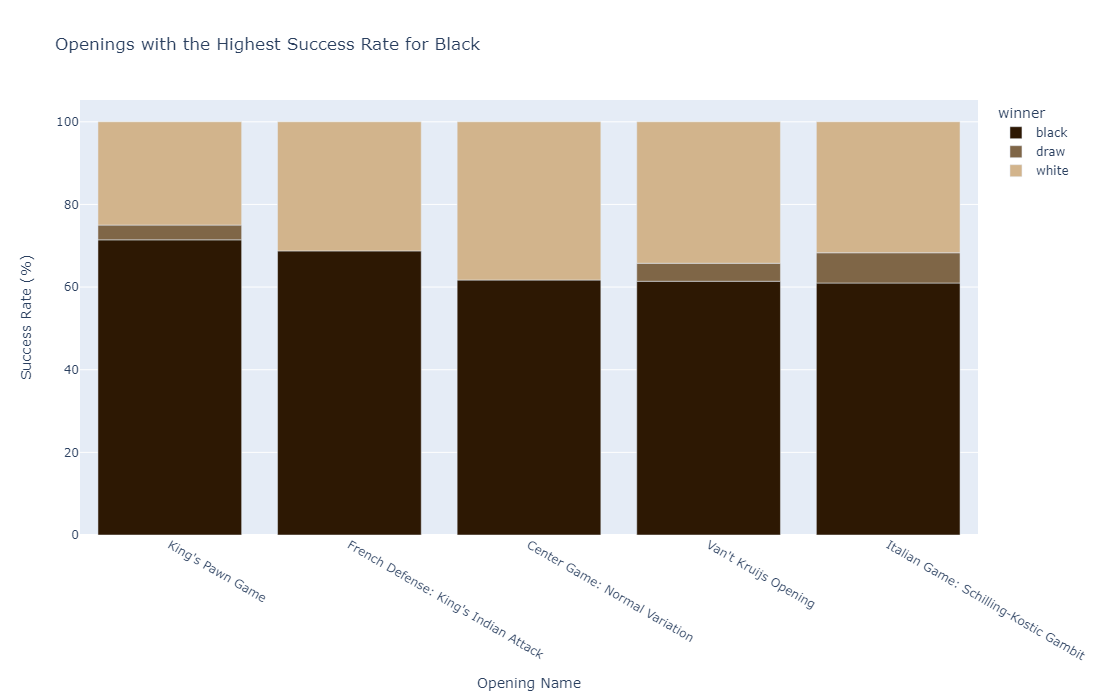

In [17]:
# Plot das aberturas com a maior taxa de sucesso para peças pretas
fig = px.bar(best_openings_black, 
             title='Openings with the Highest Success Rate for Black',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

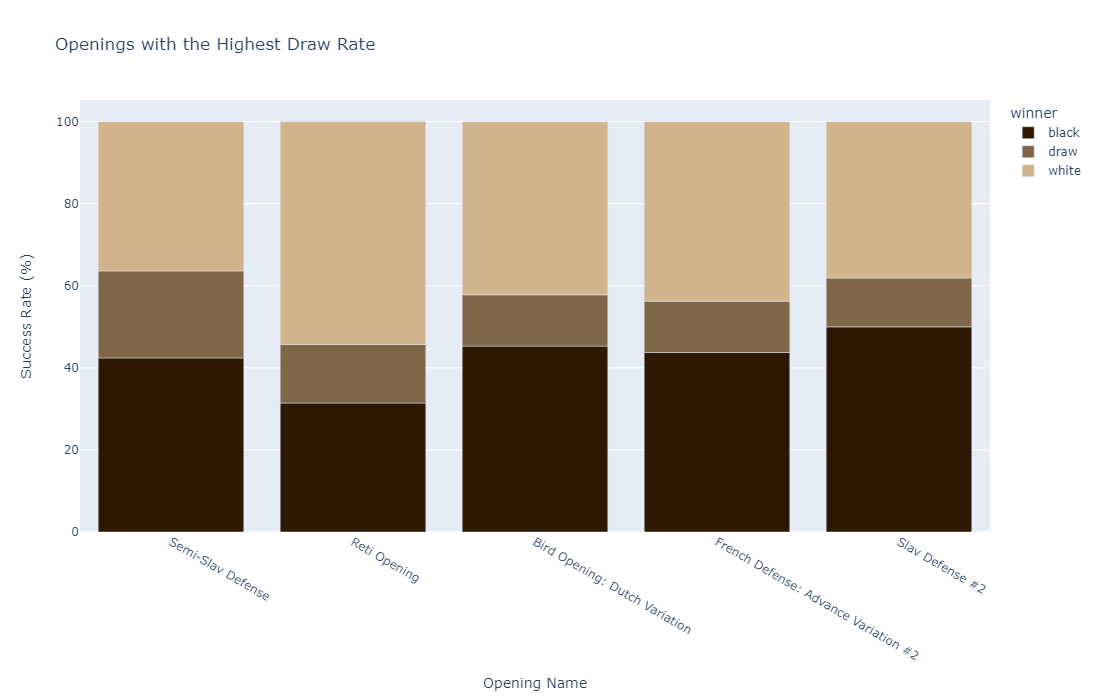

In [18]:
# Plot das aberturas com a maior taxa de empate
fig = px.bar(best_openings_draw, 
             title='Openings with the Highest Draw Rate',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

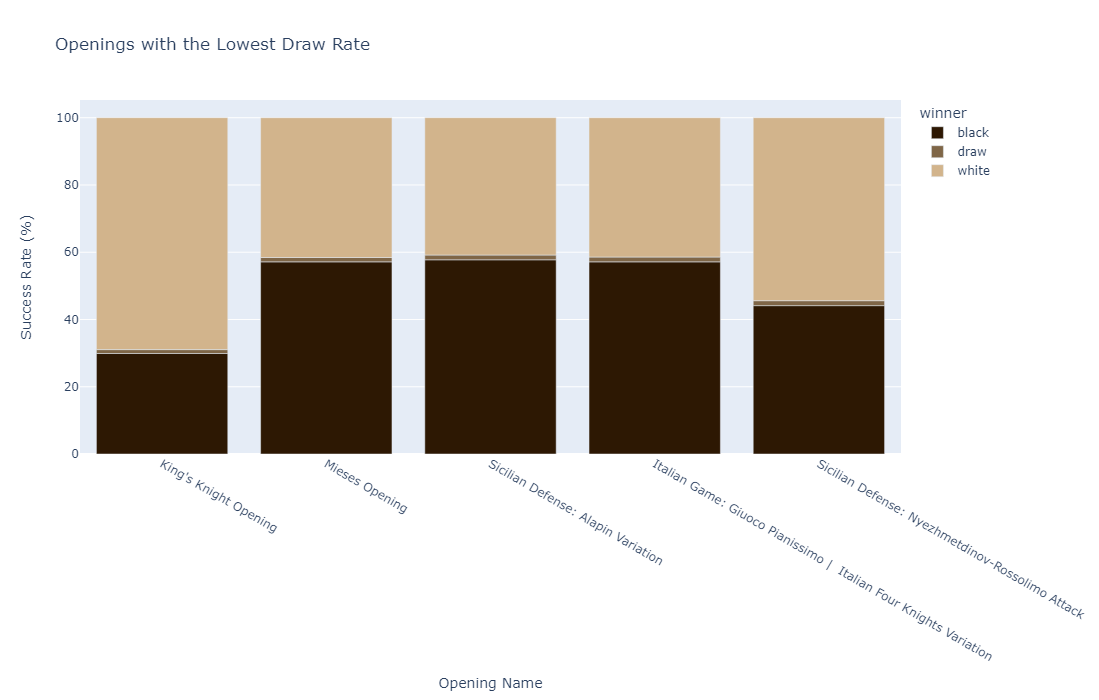

In [19]:
# Plot das aberturas com menores taxa de empate
fig = px.bar(best_openings_no_draw, 
             title='Openings with the Lowest Draw Rate',
             width=900, height=700,
             # Cores
             color='winner', 
             color_discrete_sequence=opening_colors)

# Atualizando os rótulos dos eixos
fig.update_layout(xaxis_title='Opening Name', yaxis_title='Success Rate (%)')
fig.show()

### Quantidade de lances de abertura por Rating do Jogador

In [20]:
# Criando as etiquetas e os bins para a quantidade de movimentos na abertura
labels = [f'{i} - {i+2}' for i in range(1, 28, 3)]
bins = list(range(1, 30, 3))

# Criando a coluna 'cut_opening_ply' no DataFrame 'df'
df['cut_opening_ply'] = pd.cut(df['opening_ply'], bins=bins, labels=labels)

# Calculando a distribuição percentual por classe de vencedor
qtd_moves_by_class = (
    df.groupby('winner_class', observed=False)['cut_opening_ply']
    .value_counts(normalize=True)
    .unstack() * 100
).round(2)

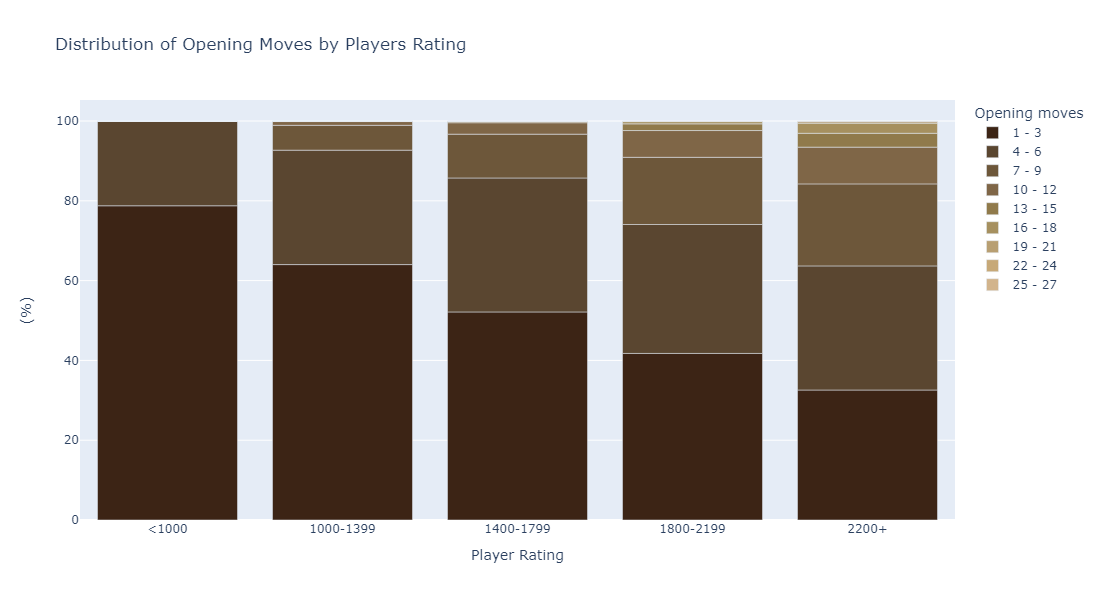

In [21]:
# Definindo a escala de cores 
wood_colors_custom = ['#3C2415', '#5A4630', '#6D573A', '#7F6647', '#907A4B', '#A6905F', '#B89F72', '#C7A978', '#D2B48C']

# Gráfico de barras
fig = px.bar(qtd_moves_by_class,
             title='Distribution of Opening Moves by Players Rating',
             width=1000, height=600,
             color_discrete_sequence=wood_colors_custom,
             labels={'winner_class': 'Player Rating', 
                     'value':'(%)', 
                     'cut_opening_ply': 'Opening moves'}
            )

fig.show()